## Import libs

In [1]:
from __future__ import print_function, division, absolute_import
import os
import GPy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import sys
sys.path.insert(0,'../..')
print(sys.path)
from mtfunc.helper import *
import safeopt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import tqdm
# plt.style.use('science')


['../..', '/Users/adrianpaeckelripoll/rbc-parameter-tuning/fig_scripts/optimizer_eval', '/opt/anaconda3/envs/env1/lib/python39.zip', '/opt/anaconda3/envs/env1/lib/python3.9', '/opt/anaconda3/envs/env1/lib/python3.9/lib-dynload', '', '/opt/anaconda3/envs/env1/lib/python3.9/site-packages', '/opt/anaconda3/envs/env1/lib/python3.9/site-packages/IPython/extensions', '/Users/adrianpaeckelripoll/.ipython']
/Users/adrianpaeckelripoll/rbc-parameter-tuning/mtfunc   was appended to PYTHONPATH


In [2]:

rnd_opt_cst=get_data('NL_opt/mrnd_opt_cst_winter_3_1_2_2022_03_15_0536.npy')
rnd_opt_par=get_data('NL_opt/mrnd_opt_par_winter_3_1_2_2022_03_15_0536.npy')


#  Kernel evaluation

In [18]:
hp_list=[1,2,3,4]
tlim=50
height=8
height2=6

import glob
paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_qs_32_model/x_post_*')
file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
for i, beta in enumerate(betas):
    if beta.startswith('0.'):
        betas[i]=float(beta.replace('0.','.'))
    elif beta.startswith('0'):
        betas[i]=float(beta.replace('0','.'))       
    else:
        betas[i]=float(beta) # convert to float and add . to 05

optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
dates=[file_path[-19:-4] for file_path in file_paths] # get betas

par=[]
for i,path in enumerate(paths):
    par.append(get_data(path))



par_df=pd.DataFrame({'optype':optypes,'beta':betas,'par':par,'date':dates})
par_df=par_df.set_index(['beta','optype']).sort_index()
print(np.any(par_df.index.duplicated()))
par_df=par_df[~par_df.index.duplicated()]

paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_qs_32_model/y_post*')
file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
hpar=[file_path.split('_')[2].strip('b') for file_path in file_paths] # get hp names
for i, beta in enumerate(betas):
    if beta.startswith('0.'):
        betas[i]=float(beta.replace('0.','.'))
    elif beta.startswith('0'):
        betas[i]=float(beta.replace('0','.'))        
    else:
        betas[i]=float(beta) # convert to float and add . to 05

optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
dates=[file_path[-19:-4] for file_path in file_paths] # get betas
ct=10 #convergence time
mae_=[]
mae=[]
cnst10=[]
cnstavg=[]
sftavg=[]
cts=[]
cnst_hist=[]
cnst_=[]
sft_=[]
cst_=[]
for i,path in enumerate(paths):
    cst=get_data(path)[:]
    cst_.append(cst)
    err=-rnd_opt_cst.flatten()[ct:len(cst)]-cst[ct:,0]
    mae_.append(np.abs(err))
    mae.append(np.abs(err).mean())
    cnst=get_data(path)[:,1]
    sft=get_data(path)[:,2]        
    cnst_hist.append(np.histogram(cnst,bins=20,range=(-0.5,0)))
    cnst10.append((cnst<-2e-2).astype(int).sum())
    cnst[cnst>0]=0
    cnst_.append(-cnst*50)
    cnstavg.append(cnst.mean()*50)
    sft[sft>0]=0
    sft_.append(-sft*50) 
    sftavg.append(sft.mean()*50)


eval_df=pd.DataFrame({'optype':optypes,'beta':betas,'mae':mae,'cnst':cnstavg,'sft':sftavg,'cst_':cst_,'mae_':mae_,'hst':cnst_hist,'date':dates,
                     'cnst10':cnst10,'cnst_':cnst_,'sft_':sft_,'hpar':hpar})
eval_df=eval_df.set_index(['beta','optype']).sort_index()
print(np.any(eval_df.index.duplicated()))
# eval_df=eval_df[~eval_df.index.duplicated()]


True
True


In [19]:
eval_df.sort_values(['mae'])

mae       cnst       sft  \
beta optype                                  
0.5  CSBO    0.335519  -1.203868 -1.036670   
     SBO     0.341826  -1.268368 -1.614520   
     CSBO    0.342068  -1.625381  0.000000   
     CSBO    0.408856  -1.088000 -1.068939   
2.0  CSBO    0.419779  -0.492090 -0.466997   
1.0  BO      0.435745 -24.641636 -2.108998   
     BO      0.435745 -24.641636 -2.108998   
0.5  BO      0.440616 -24.647583 -2.109234   
1.0  BO      0.442224 -24.651863 -2.109354   
0.5  BO      0.445817 -24.657374 -2.110496   
     BO      0.445817 -24.657374 -2.110496   
1.0  SBO     0.546467  -1.357614 -1.490405   
     CSBO    0.563638  -1.157480 -0.309778   
2.0  SBO     0.649150  -0.436940 -1.508731   
1.0  CSBO    0.674939  -1.781284 -0.113114   
0.5  CSBO    0.699149  -2.313640 -0.213950   
1.0  SBO     0.712122  -2.470726  0.000000   
0.5  SBO     0.714034  -1.081333 -1.586372   
2.0  CSBO    0.714144  -1.000897  0.000000   
0.5  SBO     0.734728  -3.711878  0.000000   
2.0  CSBO    0.737933  -1.239314 -0.409012   
1.0  CSBO    0.743239  -0.436333 -0.617335   
2.0  SBO     0.750048  -1.340742 -1.403473   
0.5  CSBO    0.754654  -2.090261 -0.211711   
2.0  BO      0.769265 -21.283679 -2.119730   
1.0  CSBO    0.863069  -1.637912  0.000000   
     BO      0.884901 -16.761522  0.000000   
2.0  BO      0.911653 -21.551897 -2.127826   
     BO      0.911653 -21.551897 -2.127826   
     SBO     0.937554  -1.873986  0.000000   
     BO      0.979064 -18.873005 -2.069692   
1.0  CSBO    0.988328  -1.907306 -0.238866   
0.5  BO      1.075890 -22.637272  0.000000   
     SBO     1.106064  -3.832892 -0.298967   
     BO      1.128332 -15.848704 -1.987049   
2.0  BO      1.134009 -18.479234  0.000000   
     CSBO    1.139407  -1.865861 -0.244699   
1.0  BO      1.229475 -19.423077 -2.033871   
0.5  SBO     1.290349  -3.336847 -0.243714   
1.0  SBO     1.337025  -3.790979 -0.340509   
2.0  CSBO    1.524882  -1.067224 -0.068139   
     SBO     1.548107  -2.748777 -0.360292   
     SBO     1.670572  -2.089335 -0.632792   
1.0  SBO     1.966689  -3.664191 -0.160008   
     SBO     2.048217  -3.122871 -0.133930   
     SBOb    2.183434  -0.815269  0.000000   
0.5  SBOb    2.476175  -1.195512  0.000000   
2.0  SBOb    3.301415  -1.078900  0.000000   
0.5  SBOb    4.210570  -2.016102 -0.731850   
     SBOb    4.367987  -2.307504 -0.728391   
1.0  SBOb    4.447220  -1.083604 -0.476252   
     SBOb    4.455076  -2.051231 -0.289083   
0.5  SBOb    4.494330  -0.488646 -0.416961   
1.0  SBOb    4.585044  -1.450716 -0.376900   
0.5  SBOb    4.626645  -0.564032 -0.445772   
2.0  SBOb    4.635592  -0.659921 -0.258988   
     SBOb    4.674137  -0.889764 -0.374969   
     SBOb    4.805541  -0.735356 -0.204964   
1.0  SBOb    4.850151  -1.107812 -0.364007   
2.0  SBOb    4.873218  -0.729364 -0.224427   

                                                          cst_  \
beta optype                                                      
0.5  CSBO    [[-4.509002670493637, 0.49869236627122576, 0.9...   
     SBO     [[-4.509002670493637, 0.49869236627122576, 0.9...   
     CSBO    [[-4.542108426810266, 0.49935526282657006, 1.0...   
     CSBO    [[-4.542359627080834, 0.49943966567556347, 0.9...   
2.0  CSBO    [[-4.540943691007371, 0.4991120858955614, 0.95...   
1.0  BO      [[-1.9735311822432884, 0.4993124462134446, -0....   
     BO      [[-1.9735311822432884, 0.4993124462134446, -0....   
0.5  BO      [[-1.9628737928844862, 0.4993123681134861, -0....   
1.0  BO      [[-1.9521919327661443, 0.49931236000508616, -0...   
0.5  BO      [[-1.9735356572332252, 0.4993124524395051, -0....   
     BO      [[-1.9735356572332252, 0.4993124524395051, -0....   
1.0  SBO     [[-4.540732009307701, 0.49921563131164903, 0.9...   
     CSBO    [[-4.5620112359632135, 0.4984318642861601, 0.9...   
2.0  SBO     [[-4.540943691007371, 0.4991120858955614, 0.95...   
1.0  CSBO    [[-4.659192294246759, 0.49786153383114196, 0.9...   
0.5  CSBO    [[-4.637237801448587, 0.498190

In [20]:
hp_list=[1,2,3,4]
tlim=50
height=8
height2=6

import glob
paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_qs_32_mtrn2/x_post_*')
file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
for i, beta in enumerate(betas):
    if beta.startswith('0.'):
        betas[i]=float(beta.replace('0.','.'))
    elif beta.startswith('0'):
        betas[i]=float(beta.replace('0','.'))       
    else:
        betas[i]=float(beta) # convert to float and add . to 05

optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
dates=[file_path[-19:-4] for file_path in file_paths] # get betas

par=[]
for i,path in enumerate(paths):
    par.append(get_data(path))



par_df_mtrn=pd.DataFrame({'optype':optypes,'beta':betas,'par':par,'date':dates})
par_df_mtrn=par_df_mtrn.set_index(['beta','optype']).sort_index()
print(np.any(par_df_mtrn.index.duplicated()))
# par_df_mtrn=par_df_mtrn[~par_df_mtrn.index.duplicated()]

paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_qs_32_mtrn2/y_post*')
file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
hpar=[file_path.split('_')[2].strip('b') for file_path in file_paths] # get hp names
for i, beta in enumerate(betas):
    if beta.startswith('0.'):
        betas[i]=float(beta.replace('0.','.'))
    elif beta.startswith('0'):
        betas[i]=float(beta.replace('0','.'))        
    else:
        betas[i]=float(beta) # convert to float and add . to 05

optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
dates=[file_path[-19:-4] for file_path in file_paths] # get betas
ct=10 #convergence time
mae_=[]
mae=[]
cnst10=[]
cnstavg=[]
sftavg=[]
cts=[]
cnst_hist=[]
cnst_=[]
sft_=[]
cst_=[]
for i,path in enumerate(paths):
    cst=get_data(path)[:]
    cst_.append(cst)
    err=-rnd_opt_cst.flatten()[ct:len(cst)]-cst[ct:,0]
    mae_.append(np.abs(err))
    mae.append(np.abs(err).mean())
    cnst=get_data(path)[:,1]
    sft=get_data(path)[:,2]        
    cnst_hist.append(np.histogram(cnst,bins=20,range=(-0.5,0)))
    cnst10.append((cnst<-2e-2).astype(int).sum())
    cnst[cnst>0]=0
    cnst_.append(-cnst*50)
    cnstavg.append(cnst.mean()*50)
    sft[sft>0]=0
    sft_.append(-sft*50) 
    sftavg.append(sft.mean()*50)


eval_df_mtrn=pd.DataFrame({'optype':optypes,'beta':betas,'mae':mae,'cnst':cnstavg,'sft':sftavg,'cst_':cst_,'mae_':mae_,'hst':cnst_hist,'date':dates,
                     'cnst10':cnst10,'cnst_':cnst_,'sft_':sft_,'hpar':hpar})
eval_df_mtrn=eval_df_mtrn.set_index(['beta','optype']).sort_index()
print(np.any(eval_df_mtrn.index.duplicated()))
# eval_df_mtrn=eval_df_mtrn[~eval_df_mtrn.index.duplicated()]


True
True


In [21]:
hp_list=[1,2,3,4]
tlim=50
height=8
height2=6

import glob
paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_qs_32_qsmtrn2/x_post_*')
file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
for i, beta in enumerate(betas):
    if beta.startswith('0.'):
        betas[i]=float(beta.replace('0.','.'))
    elif beta.startswith('0'):
        betas[i]=float(beta.replace('0','.'))       
    else:
        betas[i]=float(beta) # convert to float and add . to 05

optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
dates=[file_path[-19:-4] for file_path in file_paths] # get betas

par=[]
for i,path in enumerate(paths):
    par.append(get_data(path))



par_df=pd.DataFrame({'optype':optypes,'beta':betas,'par':par,'date':dates})
par_df=par_df.set_index(['beta','optype']).sort_index()
print(np.any(par_df.index.duplicated()))
# par_df=par_df[~par_df.index.duplicated()]

paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_qs_32_qsmtrn2/y_post*')
file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
hpar=[file_path.split('_')[2].strip('b') for file_path in file_paths] # get hp names
for i, beta in enumerate(betas):
    if beta.startswith('0.'):
        betas[i]=float(beta.replace('0.','.'))
    elif beta.startswith('0'):
        betas[i]=float(beta.replace('0','.'))        
    else:
        betas[i]=float(beta) # convert to float and add . to 05

optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
dates=[file_path[-19:-4] for file_path in file_paths] # get betas
ct=10 #convergence time
mae_=[]
mae=[]
cnst10=[]
cnstavg=[]
sftavg=[]
cts=[]
cnst_hist=[]
cnst_=[]
sft_=[]
cst_=[]
for i,path in enumerate(paths):
    cst=get_data(path)[:]
    cst_.append(cst)
    err=-rnd_opt_cst.flatten()[ct:len(cst)]-cst[ct:,0]
    mae_.append(np.abs(err))
    mae.append(np.abs(err).mean())
    cnst=get_data(path)[:,1]
    sft=get_data(path)[:,2]        
    cnst_hist.append(np.histogram(cnst,bins=20,range=(-0.5,0)))
    cnst10.append((cnst<-2e-2).astype(int).sum())
    cnst[cnst>0]=0
    cnst_.append(-cnst*50)
    cnstavg.append(cnst.mean()*50)
    sft[sft>0]=0
    sft_.append(-sft*50) 
    sftavg.append(sft.mean()*50)


eval_df_qsmtrn=pd.DataFrame({'optype':optypes,'beta':betas,'mae':mae,'cnst':cnstavg,'sft':sftavg,'cst_':cst_,'mae_':mae_,'hst':cnst_hist,'date':dates,
                     'cnst10':cnst10,'cnst_':cnst_,'sft_':sft_,'hpar':hpar})
eval_df_qsmtrn=eval_df_qsmtrn.set_index(['beta','optype']).sort_index()
print(np.any(eval_df_qsmtrn.index.duplicated()))
# eval_df_qsmtrn=eval_df_qsmtrn[~eval_df_qsmtrn.index.duplicated()]


True
True


In [22]:
eval_df.sort_values(['mae','cnst','sft'])

mae       cnst       sft  \
beta optype                                  
0.5  CSBO    0.335519  -1.203868 -1.036670   
     SBO     0.341826  -1.268368 -1.614520   
     CSBO    0.342068  -1.625381  0.000000   
     CSBO    0.408856  -1.088000 -1.068939   
2.0  CSBO    0.419779  -0.492090 -0.466997   
1.0  BO      0.435745 -24.641636 -2.108998   
     BO      0.435745 -24.641636 -2.108998   
0.5  BO      0.440616 -24.647583 -2.109234   
1.0  BO      0.442224 -24.651863 -2.109354   
0.5  BO      0.445817 -24.657374 -2.110496   
     BO      0.445817 -24.657374 -2.110496   
1.0  SBO     0.546467  -1.357614 -1.490405   
     CSBO    0.563638  -1.157480 -0.309778   
2.0  SBO     0.649150  -0.436940 -1.508731   
1.0  CSBO    0.674939  -1.781284 -0.113114   
0.5  CSBO    0.699149  -2.313640 -0.213950   
1.0  SBO     0.712122  -2.470726  0.000000   
0.5  SBO     0.714034  -1.081333 -1.586372   
2.0  CSBO    0.714144  -1.000897  0.000000   
0.5  SBO     0.734728  -3.711878  0.000000   
2.0  CSBO    0.737933  -1.239314 -0.409012   
1.0  CSBO    0.743239  -0.436333 -0.617335   
2.0  SBO     0.750048  -1.340742 -1.403473   
0.5  CSBO    0.754654  -2.090261 -0.211711   
2.0  BO      0.769265 -21.283679 -2.119730   
1.0  CSBO    0.863069  -1.637912  0.000000   
     BO      0.884901 -16.761522  0.000000   
2.0  BO      0.911653 -21.551897 -2.127826   
     BO      0.911653 -21.551897 -2.127826   
     SBO     0.937554  -1.873986  0.000000   
     BO      0.979064 -18.873005 -2.069692   
1.0  CSBO    0.988328  -1.907306 -0.238866   
0.5  BO      1.075890 -22.637272  0.000000   
     SBO     1.106064  -3.832892 -0.298967   
     BO      1.128332 -15.848704 -1.987049   
2.0  BO      1.134009 -18.479234  0.000000   
     CSBO    1.139407  -1.865861 -0.244699   
1.0  BO      1.229475 -19.423077 -2.033871   
0.5  SBO     1.290349  -3.336847 -0.243714   
1.0  SBO     1.337025  -3.790979 -0.340509   
2.0  CSBO    1.524882  -1.067224 -0.068139   
     SBO     1.548107  -2.748777 -0.360292   
     SBO     1.670572  -2.089335 -0.632792   
1.0  SBO     1.966689  -3.664191 -0.160008   
     SBO     2.048217  -3.122871 -0.133930   
     SBOb    2.183434  -0.815269  0.000000   
0.5  SBOb    2.476175  -1.195512  0.000000   
2.0  SBOb    3.301415  -1.078900  0.000000   
0.5  SBOb    4.210570  -2.016102 -0.731850   
     SBOb    4.367987  -2.307504 -0.728391   
1.0  SBOb    4.447220  -1.083604 -0.476252   
     SBOb    4.455076  -2.051231 -0.289083   
0.5  SBOb    4.494330  -0.488646 -0.416961   
1.0  SBOb    4.585044  -1.450716 -0.376900   
0.5  SBOb    4.626645  -0.564032 -0.445772   
2.0  SBOb    4.635592  -0.659921 -0.258988   
     SBOb    4.674137  -0.889764 -0.374969   
     SBOb    4.805541  -0.735356 -0.204964   
1.0  SBOb    4.850151  -1.107812 -0.364007   
2.0  SBOb    4.873218  -0.729364 -0.224427   

                                                          cst_  \
beta optype                                                      
0.5  CSBO    [[-4.509002670493637, 0.49869236627122576, 0.9...   
     SBO     [[-4.509002670493637, 0.49869236627122576, 0.9...   
     CSBO    [[-4.542108426810266, 0.49935526282657006, 1.0...   
     CSBO    [[-4.542359627080834, 0.49943966567556347, 0.9...   
2.0  CSBO    [[-4.540943691007371, 0.4991120858955614, 0.95...   
1.0  BO      [[-1.9735311822432884, 0.4993124462134446, -0....   
     BO      [[-1.9735311822432884, 0.4993124462134446, -0....   
0.5  BO      [[-1.9628737928844862, 0.4993123681134861, -0....   
1.0  BO      [[-1.9521919327661443, 0.49931236000508616, -0...   
0.5  BO      [[-1.9735356572332252, 0.4993124524395051, -0....   
     BO      [[-1.9735356572332252, 0.4993124524395051, -0....   
1.0  SBO     [[-4.540732009307701, 0.49921563131164903, 0.9...   
     CSBO    [[-4.5620112359632135, 0.4984318642861601, 0.9...   
2.0  SBO     [[-4.540943691007371, 0.4991120858955614, 0.95...   
1.0  CSBO    [[-4.659192294246759, 0.49786153383114196, 0.9...   
0.5  CSBO    [[-4.637237801448587, 0.498190

In [44]:
eval_df_mtrn.sort_values(['mae','cnst','sft'])

mae       cnst  sft  \
beta optype                             
2.0  CSBO    0.383859  -0.163874  0.0   
0.5  BO      0.398809 -24.644574  0.0   
1.0  SBO     0.426458   0.000000  0.0   
0.5  CSBO    0.464508  -0.623955  0.0   
1.0  CSBO    0.466921  -0.722082  0.0   
2.0  CSBO    0.486010  -0.452862  0.0   
     SBO     0.536831  -1.450103  0.0   
1.0  CSBO    0.539396  -0.781076  0.0   
     BO      0.584709 -23.012821  0.0   
0.5  SBO     0.589215  -0.425551  0.0   
1.0  SBO     0.628316  -2.364365  0.0   
2.0  BO      0.640886 -21.195700  0.0   
     SBO     0.661041  -2.410099  0.0   
0.5  CSBO    0.695257  -0.936108  0.0   
     SBO     0.760105  -1.554803  0.0   
     BO      0.864696 -21.214096  0.0   
2.0  BO      0.888418 -19.329666  0.0   
1.0  BO      0.891850 -22.152449  0.0   
     SBOb    2.657093  -1.875541  0.0   
     SBOb    2.677105  -1.450202  0.0   
2.0  SBOb    2.721956  -1.034543  0.0   
0.5  SBOb    2.906689  -1.502119  0.0   
     SBOb    2.922119  -1.569198  0.0   
2.0  SBOb    3.390064  -0.721179  0.0   

                                                          cst_  \
beta optype                                                      
2.0  CSBO    [[-4.5226056491359445, 0.49935526281676884, 1....   
0.5  BO      [[1.355710229751255, -0.5004709798402401, 0.09...   
1.0  SBO     [[0.9802876570055323, 0.007179713893987127, 0....   
0.5  CSBO    [[1.3631993016281525, -0.5009815458298906, 0.0...   
1.0  CSBO    [[0.9802876570055323, 0.007179713893987127, 0....   
2.0  CSBO    [[-3.225483841848165, 0.4982744987216509, 0.74...   
     SBO     [[-3.225483841848165, 0.4982744987216509, 0.74...   
1.0  CSBO    [[1.7167665244231873, -0.5048303075977756, 0.0...   
     BO      [[1.355710229751255, -0.5004709798402401, 0.09...   
0.5  SBO     [[1.3631993016281525, -0.5009815458298906, 0.0...   
1.0  SBO     [[1.7167665244231873, -0.5048303075977756, 0.0...   
2.0  BO      [[1.355710229751255, -0.5004709798402401, 0.09...   
     SBO     [[-4.5226056491359445, 0.49935526281676884, 1....   
0.5  CSBO    [[2.055034469187736, -0.5071501830936384, 0.09...   
     SBO     [[2.055034469187736, -0.5071501830936384, 0.09...   
     BO      [[1.355710229751255, -0.5004709798402401, 0.09...   
2.0  BO      [[1.355710229751255, -0.5004709798402401, 0.09...   
1.0  BO      [[1.355710229751255, -0.5004709798402401, 0.09...   
     SBOb    [[1.440516703277086, -0.06541573520281631, 0.0...   
     SBOb    [[0.9802876570055323, 0.007179713893987127, 0....   
2.0  SBOb    [[-2.588651518885795, 0.49687879552488906, 0.5...   
0.5  SBOb    [[-0.884294962716865, 0.26182236234721473, 0.0...   
     SBOb    [[-1.3045307625782003, 0.38136828565920183, 0....   
2.0  SBOb    [[-3.225483841848165, 0.4982744987216509, 0.74...   

                                                          mae_  \
beta optype                                                      
2.0  CSBO    [0.16937333347402506, 0.2011349898187178, 0.14...   
0.5  BO      [0.1064362967065764, 0.10268472539521634, 1.30...   
1.0  SBO     [0.44685561771800364, 0.2552279865309308, 0.22...   
0.5  CSBO    [0.6797732096932694, 0.2962445710377226, 0.543...   
1.0  CSBO    [0.2471098273279062, 0.3656619148369984, 0.462...   
2.0  CSBO    [0.32855725169145567, 0.2973779283081166, 0.31...   
     SBO     [0.6155563607743999, 1.1186682242816568, 1.679...   
1.0  CSBO    [0.48252010308782234, 0.5572104503086903, 0.34...   
     BO      [0.11635866154246832, 0.30773785435219914, 2.1...   
0.5  SBO     [0.848432405067546, 1.156048505441393, 0.49552...   
1.0  SBO     [0.008355837498195573, 0.6388507734257036, 0.0...   
2.0  BO      [0.10606067619173798, 0.10549818626419927, 1.9...   
     SBO     [5.819075365272539, 1.5277533173642937, 1.3993...   
0.5  CSBO    [1.5464550187905872, 1.5067264414205574, 0.975...   
     SBO     [3.088841801859911, 0.6395968426242256, 1.2724...   
     BO      [0.1064362967065764, 0.10268472539521634, 1.30...   
2.0  BO      [0.10633331684156344, 1.073138667

In [23]:
eval_df_qsmtrn.sort_values(['mae','cnst','sft'])

mae       cnst       sft  \
beta optype                                  
0.5  CSBO    0.174433  -0.960060 -0.742965   
     CSBO    0.295703  -1.538969 -0.527371   
2.0  CSBO    0.397444  -0.830709 -0.092020   
     CSBO    0.397924  -0.712984 -0.058118   
1.0  BO      0.400289 -24.648100 -2.108414   
     BO      0.400289 -24.648100 -2.108414   
0.5  CSBO    0.402695  -1.051456 -0.397304   
     BO      0.404275 -24.654010 -2.108600   
1.0  BO      0.406023 -24.658215 -2.108747   
0.5  BO      0.409271 -24.663927 -2.109859   
     BO      0.409271 -24.663927 -2.109859   
1.0  CSBO    0.450686  -0.937632 -0.741660   
0.5  SBO     0.466304  -1.030066 -1.567171   
1.0  CSBO    0.537300  -1.184271 -0.313652   
0.5  CSBO    0.561752  -2.380931 -0.401675   
2.0  BO      0.727379 -21.344266 -2.118962   
     CSBO    0.741955  -1.050629 -0.070832   
     SBO     0.873148  -1.448169 -1.093060   
1.0  CSBO    0.912894  -1.499376 -0.108837   
2.0  BO      0.916042 -21.617603 -2.137086   
     BO      0.916042 -21.617603 -2.137086   
     BO      0.982388 -18.626357 -2.065756   
0.5  SBO     1.019710  -2.697288 -1.275255   
     BO      1.138987 -15.825371 -1.988402   
2.0  CSBO    1.156331  -0.389181 -0.033832   
0.5  SBO     1.198390  -2.122927 -0.654388   
1.0  BO      1.235405 -19.418581 -2.034469   
0.5  SBO     1.294385  -3.891278 -0.409203   
1.0  SBO     1.439406   0.000000 -1.462584   
     SBO     1.494854  -1.217883 -1.037187   
     CSBO    1.599439  -1.227880 -0.307001   
2.0  SBO     1.888792  -1.235966 -0.424242   
1.0  SBO     2.279143  -3.104239 -0.100949   
     SBO     2.405014  -3.073857 -0.098506   
2.0  SBO     2.536540  -1.338987 -0.019006   
     SBO     2.544753  -1.868801 -0.030569   
1.0  SBOb    4.102405  -1.312681 -0.427545   
0.5  SBOb    4.167226  -2.333602 -0.580557   
1.0  SBOb    4.280952  -1.109082 -0.317494   
     SBOb    4.289758  -1.694320 -0.432415   
2.0  SBOb    4.344747  -1.043963 -0.290645   
0.5  SBOb    4.368118  -1.634335 -0.460876   
2.0  SBOb    4.399927  -1.004157 -0.297294   
1.0  SBOb    4.413961  -1.765956 -0.278555   
0.5  SBOb    4.437787  -1.613599 -0.481778   
2.0  SBOb    4.442671  -0.624152 -0.162044   
0.5  SBOb    4.541649  -2.470923 -0.471323   
2.0  SBOb    4.602575  -0.435794 -0.124433   

                                                          cst_  \
beta optype                                                      
0.5  CSBO    [[-4.501154625237228, 0.4986546008542365, 0.94...   
     CSBO    [[-4.657376108532808, 0.49785950203469725, 0.9...   
2.0  CSBO    [[-4.54255437062048, 0.49925296668248337, 0.95...   
     CSBO    [[-4.542066580587364, 0.4988796677392986, 0.95...   
1.0  BO      [[-1.9735311822432884, 0.4993124462134446, -0....   
     BO      [[-1.9735311822432884, 0.4993124462134446, -0....   
0.5  CSBO    [[-4.644915281185373, 0.4979522426175052, 0.95...   
     BO      [[-1.9628737928844862, 0.4993123681134861, -0....   
1.0  BO      [[-1.9521919327661443, 0.49931236000508616, -0...   
0.5  BO      [[-1.9735356572332252, 0.4993124524395051, -0....   
     BO      [[-1.9735356572332252, 0.4993124524395051, -0....   
1.0  CSBO    [[-4.541030085317124, 0.4992156313187684, 0.95...   
0.5  SBO     [[-4.501154625237228, 0.4986546008542365, 0.94...   
1.0  CSBO    [[-4.637445308901041, 0.4983776592468817, 0.95...   
0.5  CSBO    [[-4.644915281185373, 0.4979522426175052, 0.95...   
2.0  BO      [[-1.6861644928142185, 0.4993121450299873, -0....   
     CSBO    [[-4.54255437062048, 0.49925296668248337, 0.95...   
     SBO     [[-4.542066580587364, 0.4988796677392986, 0.95...   
1.0  CSBO    [[-4.637445308901041, 0.4983776592468817, 0.95...   
2.0  BO      [[-1.9735220094517727, 0.49931243336597675, -0...   
     BO      [[-1.9735220094517727, 0.49931243336597675, -0...   
     BO      [[-1.9181561894491228, 0.49931234319851314, -0...   
0.5  SBO     [[-4.657376108532808, 0.49785950203469725, 0.9...   
     BO      [[-1.7176412606071958, 0.49931218539874067, -0...   
2

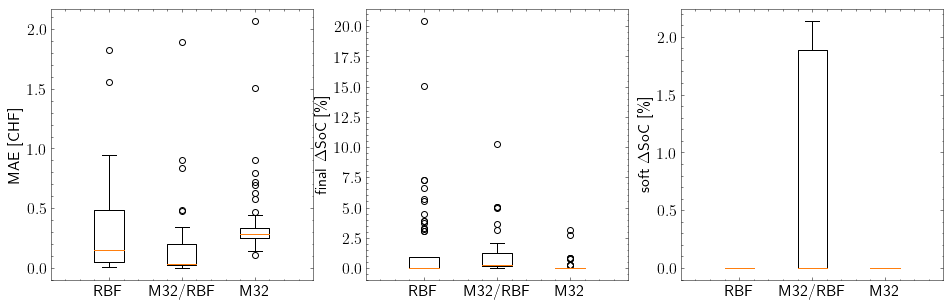

In [45]:

beta0=0.5
beta1=0.5
beta=2
height=5

with plt.style.context('science'):
    plt.rcParams.update({'font.size': 16})            
    fig,ax=plt.subplots(1,3,figsize=(16,height))

    ax[0].boxplot(eval_df.loc[eval_df.hpar=='loglike5'].loc[(beta0,'CSBO')].mae_,showfliers=True,labels=['RBF'],positions=[0/4],widths=0.1)
    ax[0].boxplot(eval_df_qsmtrn.loc[eval_df_qsmtrn.hpar=='loglike4'].loc[(beta1,'CSBO')].mae_,showfliers=True,labels=['M32/RBF'],positions=[1/4],widths=0.1)      
    ax[0].boxplot(eval_df_mtrn.loc[eval_df_mtrn.hpar=='loglike1'].loc[(beta,'CSBO')].mae_,showfliers=True,labels=['M32'],positions=[2/4],widths=0.1)
#     ax[0].boxplot(eval_df_qsmtrn.loc[(beta,'CSBO')].mae_,showfliers=True,labels=['RBF/Matern32'],positions=[2/4],widths=0.1)    
    ax[0].set_ylabel(r'MAE [CHF]')
    ax[0].set_xlim([-0.2,0.7]) 
    
    ax[1].boxplot(eval_df.loc[eval_df.hpar=='loglike5'].loc[(beta0,'CSBO')].cnst_,showfliers=True,labels=['RBF'],positions=[0/4],widths=0.1)
    ax[1].boxplot(eval_df_qsmtrn.loc[eval_df_qsmtrn.hpar=='loglike4'].loc[(beta1,'CSBO')].cnst_,showfliers=True,labels=['M32/RBF'],positions=[1/4],widths=0.1)      
    ax[1].boxplot(eval_df_mtrn.loc[eval_df_mtrn.hpar=='loglike1'].loc[(beta,'CSBO')].cnst_,showfliers=True,labels=['M32'],positions=[2/4],widths=0.1)
    ax[1].set_ylabel(r'final $\Delta$SoC [\%]')
    ax[1].set_xlim([-0.2,0.7]) 
    
    ax[2].boxplot(eval_df.loc[eval_df.hpar=='loglike5'].loc[(beta0,'CSBO')].sft_,showfliers=True,labels=['RBF'],positions=[0/4],widths=0.1)
    ax[2].boxplot(eval_df_qsmtrn.loc[eval_df_qsmtrn.hpar=='loglike4'].loc[(beta1,'CSBO')].sft_,showfliers=True,labels=['M32/RBF'],positions=[1/4],widths=0.1)      
    ax[2].boxplot(eval_df_mtrn.loc[eval_df_mtrn.hpar=='loglike1'].loc[(beta,'CSBO')].sft_,showfliers=True,labels=['M32'],positions=[2/4],widths=0.1)
    ax[2].set_ylabel(r'soft $\Delta$SoC [\%]')     
    ax[2].set_xlim([-0.2,0.7]) 
#                 plt.ylim([-0.001,None])
#             plt.yscale('log')
    #     plt.ylabel(r'$\textrm{R}^2$')
#         plt.locator_params(axis="y", nbins=5) 
#         plt.margins(tight=True)  
#     plt.legend(['beta'])
plt.savefig(f'QsQf/kernels_mae_qs_qf_boxplotll5.pdf')
plt.show()

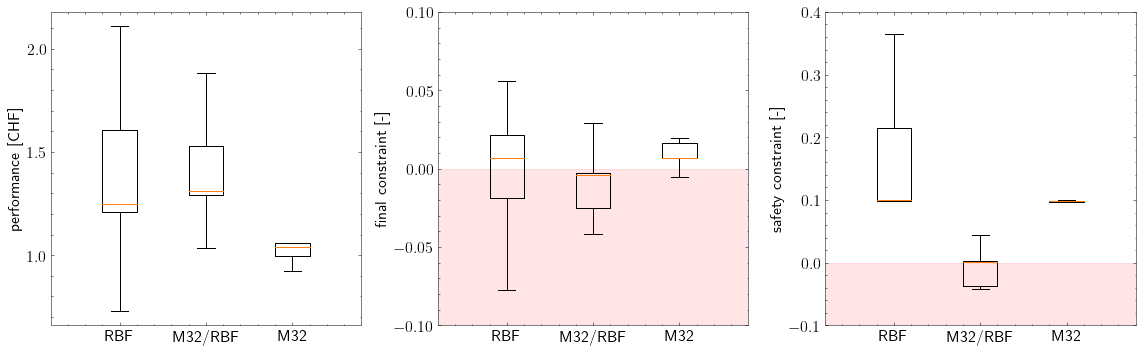

In [57]:
beta0=0.5
beta1=0.5
beta=2
height=5

t0=15

with plt.style.context('science'):
    plt.rcParams.update({'font.size': 16})            
    fig,ax=plt.subplots(1,3,figsize=(16,height))

    ax[0].boxplot(eval_df.loc[eval_df.hpar=='loglike5'].loc[(beta0,'CSBO')].cst_[t0:,0],showfliers=False,labels=['RBF'],positions=[0/4],widths=0.1)
    ax[0].boxplot(eval_df_qsmtrn.loc[eval_df_qsmtrn.hpar=='loglike4'].loc[(beta1,'CSBO')].cst_[t0:,0],showfliers=False,labels=['M32/RBF'],positions=[1/4],widths=0.1)      
    ax[0].boxplot(eval_df_mtrn.loc[eval_df_mtrn.hpar=='loglike1'].loc[(beta,'CSBO')].cst_[t0:,0],showfliers=False,labels=['M32'],positions=[2/4],widths=0.1)
#     ax[0].boxplot(eval_df_qsmtrn.loc[(beta,'CSBO')].mae_,showfliers=True,labels=['RBF/Matern32'],positions=[2/4],widths=0.1)    
    ax[0].set_ylabel(r'performance [CHF]')
    ax[0].set_xlim([-0.2,0.7]) 
    
    ax[1].boxplot(eval_df.loc[eval_df.hpar=='loglike5'].loc[(beta0,'CSBO')].cst_[:,1],showfliers=False,labels=['RBF'],positions=[0/4],widths=0.1)
    ax[1].boxplot(eval_df_qsmtrn.loc[eval_df_qsmtrn.hpar=='loglike4'].loc[(beta1,'CSBO')].cst_[:,1],showfliers=False,labels=['M32/RBF'],positions=[1/4],widths=0.1)      
    ax[1].boxplot(eval_df_mtrn.loc[eval_df_mtrn.hpar=='loglike1'].loc[(beta,'CSBO')].cst_[:,1],showfliers=False,labels=['M32'],positions=[2/4],widths=0.1)
    ax[1].set_ylabel(r'final constraint [-]')
    ax[1].set_xlim([-0.2,0.7]) 
    
    ax[2].boxplot(eval_df.loc[eval_df.hpar=='loglike5'].loc[(beta0,'CSBO')].cst_[:,2],showfliers=False,labels=['RBF'],positions=[0/4],widths=0.1)
    ax[2].boxplot(eval_df_qsmtrn.loc[eval_df_qsmtrn.hpar=='loglike4'].loc[(beta1,'CSBO')].cst_[:,2],showfliers=False,labels=['M32/RBF'],positions=[1/4],widths=0.1)      
    ax[2].boxplot(eval_df_mtrn.loc[eval_df_mtrn.hpar=='loglike1'].loc[(beta,'CSBO')].cst_[:,2],showfliers=False,labels=['M32'],positions=[2/4],widths=0.1)
    ax[2].set_ylabel(r'safety constraint [-]')     
    ax[2].set_xlim([-0.2,0.7]) 
    ax[1].fill_between(np.arange(-1,2),y1=0,y2=-2,color='red',alpha=0.1)
    ax[2].fill_between(np.arange(-1,2),y1=0,y2=-2,color='red',alpha=0.1) 
    ax[1].set_ylim([-0.1,0.1])
    ax[2].set_ylim([-0.1,0.4])
    plt.subplots_adjust(wspace=0.3)
#                 plt.ylim([-0.001,None])
#             plt.yscale('log')
    #     plt.ylabel(r'$\textrm{R}^2$')
    for axis in ax.flatten():
        axis.locator_params(axis="y", nbins=5) 
#         plt.margins(tight=True)  
#     plt.legend(['beta'])
plt.tight_layout()
plt.savefig(f'QsQf/kernels_mae_qs_qf_boxplot.pdf')
plt.show()

# Old mix

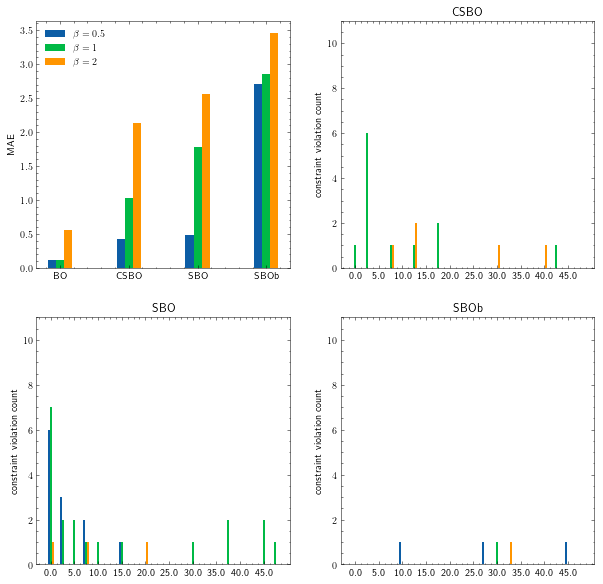

In [149]:
with plt.style.context('science'):
    x = np.arange(len(eval_df.index.levels[1]))  # the label locations
    width = 0.35  # the width of the bars

    fig, axes = plt.subplots(2,2,figsize=(10,10))
    rects1 = axes[0,0].bar(x - width/3, eval_df.loc[0.5].mae, width/3, label=r'$\beta=0.5$')
    rects2 = axes[0,0].bar(x , eval_df.loc[1].mae, width/3, label=r'$\beta=1$',tick_label=eval_df.index.levels[1])
    rects3 = axes[0,0].bar(x + width/3, eval_df.loc[2].mae, width/3, label=r'$\beta=2$')
    axes[0,0].set_ylabel('MAE')
    axes[0,0].legend()
    n_bins=20
    x = np.arange(len(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:]))  # the label locations
    for i,ax in enumerate(axes.flatten()[1:]):
        width=0.5
        op=eval_df.index.levels[1][i+1]
        rects1 = ax.bar(x - width/3, eval_df.loc[(0.5,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=0.5$')
        rects2 = ax.bar(x , eval_df.loc[(1,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=1$',
                        tick_label=(np.abs(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:])*100).round(1)[::-1])
        rects3 = ax.bar(x + width/3, eval_df.loc[(2,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=2$')
        ax.set_xticks(np.arange(0,n_bins,2))
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('constraint violation count')
        ax.set_ylim([0,11])
        ax.set_title(op)
    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)
    # ax.bar_label(rects3, padding=3)

#     fig.tight_layout()
#     axes[1,1].set_xlim([10,30])
# plt.savefig('../fig_scripts/eval_mae_cnstviol_rp_qf55_loglike3_.png')
plt.show()

In [19]:
hpar

['loglike3',
 'loglike2',
 'loglike1',
 'loglike4',
 'loglike2',
 'loglike4',
 'loglike1',
 'loglike2',
 'loglike4',
 'loglike4',
 'loglike4',
 'loglike1',
 'loglike1',
 'loglike2',
 'loglike2',
 'loglike4',
 'loglike4',
 'loglike1',
 'loglike2',
 'loglike3',
 'loglike3',
 'loglike4',
 'loglike4',
 'loglike4',
 'loglike1',
 'loglike3',
 'loglike2',
 'loglike3',
 'loglike3',
 'loglike1',
 'loglike3',
 'loglike3',
 'loglike2',
 'loglike2',
 'loglike2',
 'loglike3',
 'loglike4',
 'loglike1',
 'loglike2',
 'loglike1',
 'loglike4',
 'loglike1',
 'loglike2',
 'loglike1',
 'loglike1',
 'loglike3',
 'loglike3',
 'loglike3']

In [ ]:
with plt.style.context('science'):
    x = np.arange(len(eval_df.index.levels[1]))  # the label locations
    width = 0.35  # the width of the bars

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    rects1 = axes[0].bar(x - width/3, eval_df.loc[0.5].mae, width/3, label=r'$\beta=0.5$')
    rects2 = axes[0].bar(x , eval_df.loc[1].mae, width/3, label=r'$\beta=1$',tick_label=eval_df.index.levels[1])
    rects3 = axes[0].bar(x + width/3, eval_df.loc[2].mae, width/3, label=r'$\beta=2$')
    axes[0].set_ylabel('MAE')
    axes[0].legend()
    axes[0].set_xlabel('optimizer')

    n_bins=10
    x = np.arange(len(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:]))  # the label locations
    for i,ax in enumerate(axes.flatten()[1:]):
        width=0.5
        op=eval_df.index.levels[1][i+1]
        rects1 = ax.bar(x - width/3, eval_df.loc[(0.5,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=0.5$')
        rects2 = ax.bar(x , eval_df.loc[(1,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=1$',
                        tick_label=(np.abs(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:])*100).round().astype(int)[::-1])
        rects3 = ax.bar(x + width/3, eval_df.loc[(2,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=2$')
        ax.set_xticks(np.arange(0,n_bins,2))
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('constraint violation count')
        ax.set_ylim([0,11])
        ax.set_title(op)
        ax.set_xlabel('bin [\%]')

    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)
    # ax.bar_label(rects3, padding=3)

#     fig.tight_layout()
#     axes[1,1].set_xlim([10,30])
# plt.savefig('../fig_scripts/eval_mae_cnstviol_rp_qf55_loglike3.png')
plt.show()

In [ ]:
with plt.style.context('science'):
    n_bins=20
    x = np.arange(len(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:]))  # the label locations
    width = 0.35  # the width of the bars

    fig, axes = plt.subplots(3,figsize=(5,5))
    for i,ax in enumerate(axes.flatten()):
        op=eval_df.index.levels[1][i+1]
        rects1 = ax.bar(x - width/3, eval_df.loc[(0.5,op)].hst[0][-n_bins:], width/3, label=r'$\beta=0.5$')
        rects2 = ax.bar(x , eval_df.loc[(1,op)].hst[0][-n_bins:], width/3, label=r'$\beta=1$',
                        tick_label=(np.abs(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:])*100).round(1))
        rects3 = ax.bar(x + width/3, eval_df.loc[(2,op)].hst[0][-n_bins:], width/3, label=r'$\beta=2$')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('count')
        ax.set_title(op)
        # ax.set_xticks(eval_df.index.levels[1].values)
        ax.legend()

    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)
    # ax.bar_label(rects3, padding=3)

    fig.tight_layout()

plt.show()

In [129]:
eval_df.index.levels[1]

Index(['BO', 'CSBO', 'SBO', 'SBOb'], dtype='object', name='optype')

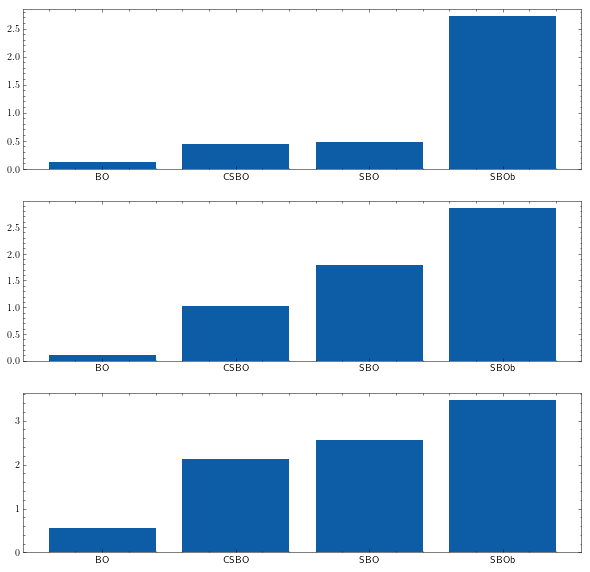

In [103]:
with plt.style.context('science'):
    fig,axes=plt.subplots(len(eval_df.index.levels[0]),figsize=(10,10))
    for i,ax in enumerate(axes.flatten()):
        df=eval_df.loc[eval_df.index.levels[0][i]]
        ax.bar(df.index,df.mae)

plt.show()

# GP evaluation

In [3]:
gps_b2=get_data('sim_data_312_winter_rp0_qf_55/CSBO_loglike3_b2__2022_03_08_0450')
gps_b05=get_data('sim_data_312_winter_rp0_qf_55/CSBO_loglike3_b05__2022_03_08_044')
bounds = [(0., 4.),(-1,1)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 100) 
optb2=safeopt.SafeOpt(gps_b2[1],parameter_set,fmin=0,num_contexts=1)
optb05=safeopt.SafeOpt(gps_b05[1],parameter_set,fmin=0,num_contexts=1)

This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning


3 3 1
context_fixed_inputs:  [(2, 0.0)]
3 3 1
context_fixed_inputs:  [(2, 1.0)]
3 3 1
context_fixed_inputs:  [(2, 0.0)]
3 3 1
context_fixed_inputs:  [(2, 1.0)]


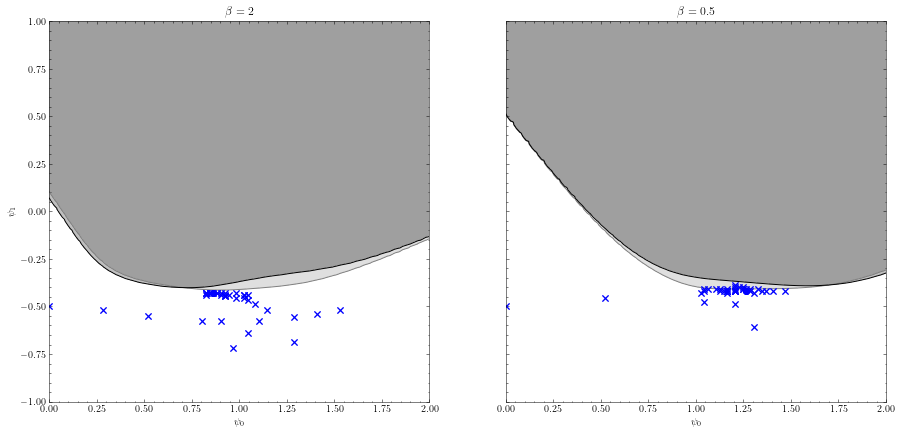

In [91]:
with plt.style.context('science'):
    fig,ax=plt.subplots(1,2,figsize=(15,7),sharey=True)
    optb2.context=[[0]]
    optb2.plot(100,levels=[-1,0,1],figure=fig,axis=ax[0], colors='grey',colorbar=False)
    optb2.context=[[1]]
    optb2.plot(100,levels=[-1,0,1],figure=fig,axis=ax[0],colors='black',colorbar=False)
    optb05.context=[[0]]
    optb05.plot(100,levels=[-1,0,1],figure=fig,axis=ax[1], colors='grey',colorbar=False)
    optb05.context=[[1]]
    optb05.plot(100,levels=[-1,0,1],figure=fig,axis=ax[1],colors='black',colorbar=False)
    ax[0].set_xlim([0,2])
    ax[1].set_xlim([0,2])
    ax[0].set_title(r'$\beta =2$')
    ax[1].set_title(r'$\beta =0.5$')
    ax[0].set_xlabel(r'$\psi_{0}$')
    ax[0].set_ylabel(r'$\psi_{1}$')    
    ax[1].set_xlabel(r'$\psi_{0}$')
    ax[1].set_title(r'$\beta =0.5$')
plt.savefig('../fig_scripts/qf_const_ctxt_loglike4.png')    
plt.show()

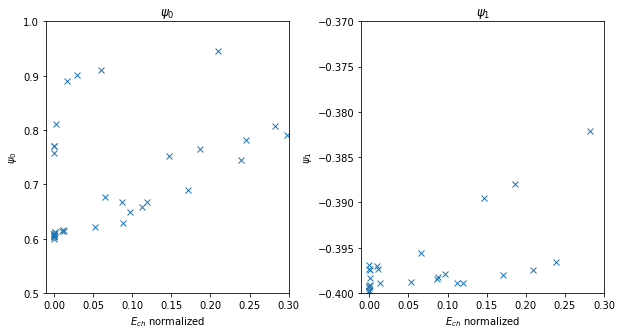

In [175]:
rnd_opt_cst=get_data('NL_opt/rnd_opt_cst_winter_3_1_2_2022_03_02_0252.npy')
rnd_opt_par=get_data('NL_opt/rnd_opt_par_winter_3_1_2_2022_03_02_0252.npy')
e_ch=get_data('sim_data_312_winter_rp0_qf_55/ech_winter_2022_03_08_0707.npy')
# rnd_opt_par=rnd_opt_par[~np.isnan(rnd_opt_par)]

fig,ax=plt.subplots(1,2,figsize=(10,5))
with plt.style.context('science'):
    ax[0].plot(e_ch[:len(rnd_opt_par)],rnd_opt_par[:,0],'x')
    ax[1].plot(e_ch[:len(rnd_opt_par)],rnd_opt_par[:,1],'x')
    ax[0].set_xlim([-0.01,0.3])
    ax[1].set_xlim([-0.01,0.3])
    ax[0].set_ylim([0.5,1])
    ax[1].set_ylim([-0.4,-0.37])
    ax[0].set_title(r'$\psi_0$')
    ax[0].set_xlabel(r'$E_{ch}$ normalized')
    ax[0].set_ylabel(r'$\psi_{0}$')    
    ax[1].set_xlabel(r'$E_{ch}$ normalized')
    ax[1].set_ylabel(r'$\psi_{1}$')
    ax[1].set_title(r'$\psi_1$')
plt.subplots_adjust(wspace=0.3)
plt.savefig('../fig_scripts/par_ech_corr_winter.png')

In [167]:
gps=get_data('sim_data_312_winter_rp0_qf_55/CSBO_loglike1_b05__2022_03_08_0421')
bounds = [(0., 4.),(-1,1)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 100) 
opt=safeopt.SafeOpt(gps,parameter_set,fmin=[-np.inf,0],num_contexts=1)


This is local package in rbc-parameter-tuning
